Notebook objective: Train & test fixed effects linear model with target encoding. Goal is to compare performance, SHAP values & fixed effects with LMM.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import optuna

from category_encoders.target_encoder import TargetEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
# Set print options
np.set_printoptions(suppress=True, precision=6, edgeitems = 7)
pd.options.display.float_format = '{:.6f}'.format
pd.set_option('display.max_columns', None)

## Preprocessing

In [3]:
random_state = 1923

In [4]:
# Read data
df = pd.read_csv("./OutputData/training_data.csv")

In [5]:
# Split features, groupings and target
X = df.drop(["life_expectancy"], axis = 1)
y = df.life_expectancy

In [6]:
# Randomly select 25 countries for the testing set
rng = np.random.default_rng(random_state)
test_countries = rng.choice(X.country, size = 25)
test_countries

array(['Guyana', 'Serbia', 'Turkmenistan', 'Samoa', 'Poland',
       'Sao Tome and Principe', 'Latvia', 'Solomon Islands', 'Bhutan',
       'Armenia', 'Mauritania', 'Mozambique', 'Malawi',
       'Dominican Republic', 'Uganda', 'Madagascar', 'Sweden',
       'Central African Republic', 'Zimbabwe', 'Mongolia', 'El Salvador',
       'Argentina', 'Comoros', 'Israel', 'Angola'], dtype=object)

In [7]:
# Split train-test
X_test = X[X["country"].isin(test_countries)]
y_test = y[X_test.index]

X_train = X[~X["country"].isin(test_countries)]
y_train = y[X_train.index]

In [8]:
# Create preprocessing pipeline
encoder = TargetEncoder(cols = "country")
scaler = MinMaxScaler()
pipeline = Pipeline([
    ("encoder", encoder), 
    ("scaler", scaler)
])

In [9]:
pipeline

Pipeline(steps=[('encoder', TargetEncoder(cols='country')),
                ('scaler', MinMaxScaler())])

In [10]:
# Preprocess features
X_train = pipeline.fit_transform(X_train, y_train)
X_test = pipeline.transform(X_test)

In [11]:
# Get back feature names
feature_name = X.columns.values.tolist()
X_train = pd.DataFrame(X_train, columns = feature_name)
X_test = pd.DataFrame(X_test, columns = feature_name)

## Testing & diagnostics

In [12]:
# Train fixed effects model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [13]:
# Make predictions on test data
preds = model.predict(X_test)

In [14]:
# Calculate MSE, RMSE, MAPE
print("MSE:")
print(round(mean_squared_error(y_test, preds), 4))

print("RMSE:")
print(round(mean_squared_error(y_test, preds, squared = False), 4))

print("MAPE:")
print(round(mean_absolute_percentage_error(y_test, preds), 4))

MSE:
64.893
RMSE:
8.0556
MAPE:
0.1053


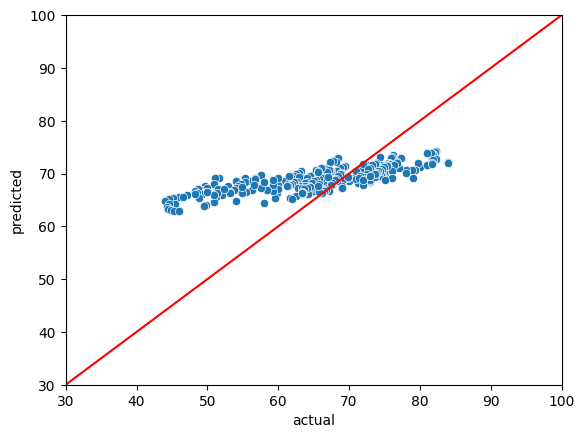

In [15]:
# Plot predicted vs. actual
_ = sns.scatterplot(x = y_test,  y = preds)
_ = plt.plot([30, 100], [30, 100], c = "red")
_ = plt.xlim(30, 100)
_ = plt.ylim(30, 100)
_ = plt.xlabel("actual")
_ = plt.ylabel("predicted")

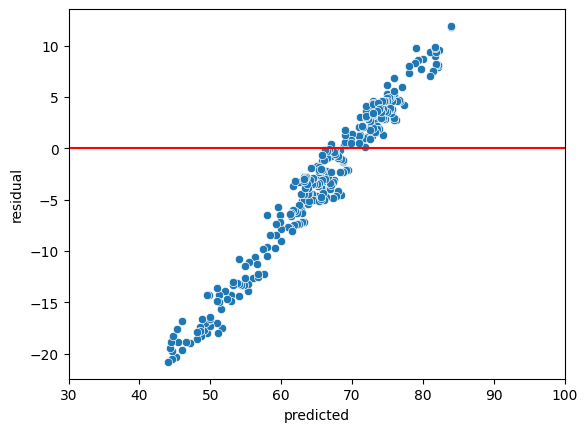

In [16]:
# Predicted vs residual
resids = y_test - preds
_ = sns.scatterplot(x = y_test, y= resids)
_ = plt.plot([30, 100], [0, 0], c = "red")
_ = plt.xlim(30, 100)
#_ = plt.ylim(-30, 30)
_ = plt.xlabel("predicted")
_ = plt.ylabel("residual")

The predictions perform better than GPBoost, worse than LMM. Pretty much right between GPBoost and LMM.

More "stable" prediction & residual pattern compared to LMM. Most countries are overpredicted, some are underpredicted.

In [17]:
# Get fitted values
fitted = model.predict(X_train)

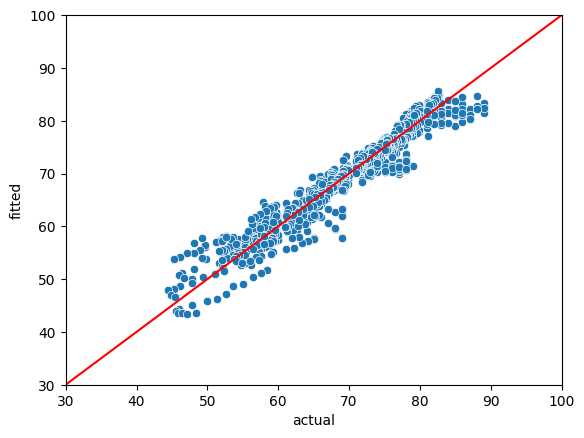

In [18]:
# Plot fitted vs. actual
_ = sns.scatterplot(x = y_train,  y = fitted)
_ = plt.plot([30, 100], [30, 100], c = "red")
_ = plt.xlim(30, 100)
_ = plt.ylim(30, 100)
_ = plt.xlabel("actual")
_ = plt.ylabel("fitted")

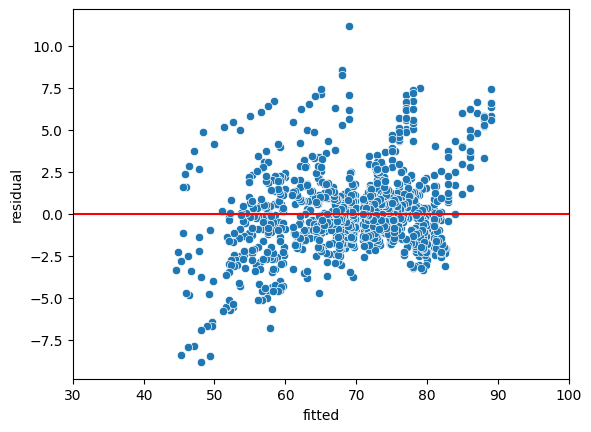

In [19]:
# Plot fitted vs. residual
fitted_resids = y_train - fitted
_ = sns.scatterplot(x = y_train, y = fitted_resids)
_ = plt.plot([30, 100], [0, 0], c = "red")
_ = plt.xlim(30, 100)
#_ = plt.ylim(-30, 30)
_ = plt.xlabel("fitted")
_ = plt.ylabel("residual")

The fitted values are close to actual, but less so compared to LMM. The residuals have less pattern as well.

## Inference

In [20]:
# Print model parameters
coefs = model.coef_
intercept = model.intercept_

In [22]:
print(pd.Series(coefs, X_test.columns))
print("intercept:                   " + str(intercept))

country                           30.284601
year                               2.647343
alcohol                           -2.157809
percentage_expenditure            -6.599639
hepatitis_b                        0.006173
measles                            0.118524
bmi                                0.735278
polio                              0.123568
total_expenditure                  0.334951
diphtheria                         0.899967
hiv_aids                          -5.032035
gdp                                7.090598
population                        -0.275146
thinness_1_19                     -0.862631
thinness_5_9                       1.226259
income_composition_of_resources    3.002651
schooling                          5.703848
developing                         0.276787
dtype: float64
intercept:                   43.831147826525495


The fitted effects & the intercept are considerably different compared to LMM.

LMM assumes an intercept of 70, compared to LM's 44, the former likely being much more robust, as it is much closer to the overall mean.

In [23]:
df.life_expectancy.mean()

69.3023044269254

In [24]:
# Get SHAP values
explainer = shap.LinearExplainer(model, X_train)
shap_values = explainer(X_train)

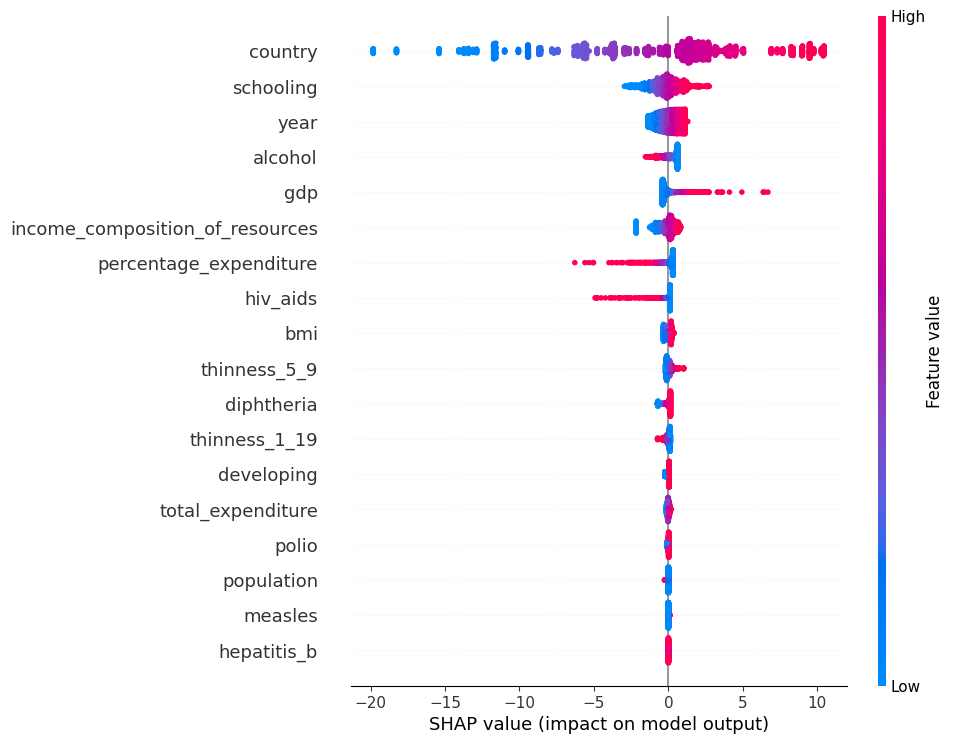

In [25]:
# SHAP summary of all features
shap.plots.beeswarm(shap_values, max_display = 20)

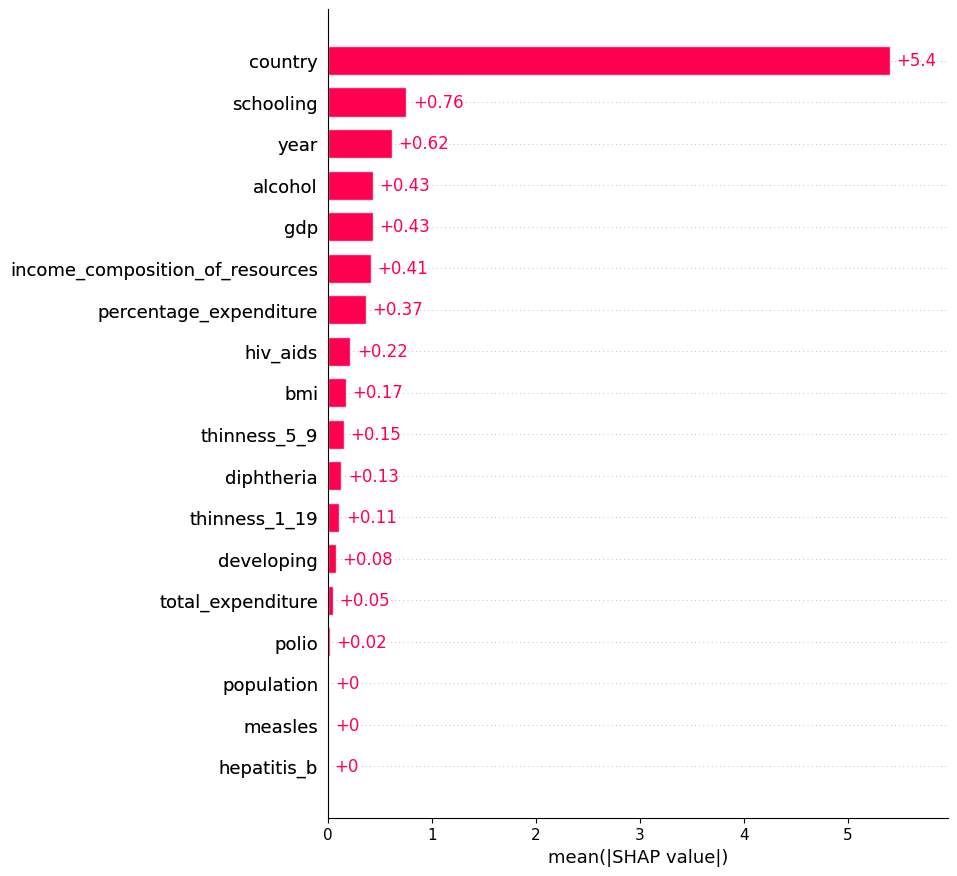

In [27]:
shap.plots.bar(shap_values, max_display = 20)

Developing loses its importance as country is back as a fixed effect predictor.

Other predictors' directions don't change by much, but some of their effects do.

Overall, the better predictive performance & more intuitive intercept suggests LMM generalizes better to previously unseen groups compared to LM, and therefore its estimated fixed effects must be more robust.